# Benchmark: Koalas (PySpark) and Dask - Local execution summary

The benchmark was performed against the 2009 - 2013 Yellow Taxi Trip Records (157 GB) from NYC Taxi and Limousine Commission (TLC) Trip Record Data.

The benchmark results below explain the performance differences between Koalas and Dask. Because the Koalas APIs are written on the top of PySpark, the results of this benchmark would apply similarly to PySpark.

### Preparation

In [0]:
import pandas as pd
from scipy import stats

def fair_avg(durations):
  """Get an average duration among multiple durations fairly by removing the first run and the best run first."""
  durations = durations[1:] 
  durations.remove(min(durations))
  return sum(durations) / len(durations)

def rename_index(df):
  """Rename operations in the average result dataframe for clarity."""
  df.index = map(
    lambda s: s.replace("filtered ", "")
      .replace("of columns", "of series")
      .replace("addition of series", "series addition")
      .replace("multiplication of series", "series multiplication")
      .replace("arithmetic ops", "arithmetic")
      .replace("count index length", "count index"),
    df.index)
  return df

def avg_result_df(file_name_prefix):
  """Get result files with the given prefix and then construct the average result dataframe."""
  dfs = []
  file_infos = dbutils.fs.ls('/FileStore/koalas-benchmark-no-parquet-cache')
  for file_info in file_infos:
    if file_info.name.startswith(file_name_prefix):
      dfs.append(pd.read_parquet('/dbfs/FileStore/koalas-benchmark-no-parquet-cache/%s' % file_info.name))
  print(f'{file_name_prefix} has {len(dfs)} runs')    
  
  avg_df = dfs[0].copy()
  for op in dfs[0].index:
    for lib in ['koalas', 'dask']:
      durations = []
      for df in dfs:
        durations.append(df.loc[op][lib])
      avg_df.loc[op][lib] = fair_avg(durations)
      
  return rename_index(avg_df)

def annotate(ax):
  """Annotate the height of each bar in the plot."""
  for p in ax.patches:
    ax.annotate("%.2fs" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

def annotate_x_times_faster(ax, x_times_list):
  """Annotate Koalas is how many times faster per operation in the plot."""
  num_ops = len(x_times_list)
  for i, p in enumerate(ax.patches):
    if i < num_ops:  # The first half of ax.patches of Koalas; we only annotate Koalas patches
      ax.annotate("%.1fx" % x_times_list[i], (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(4, 10), textcoords='offset points', fontsize=8, weight='bold', color="#585858")

local_res_df = avg_result_df('single_node_')
local_res_df.columns = ['Koalas (PySpark)', 'Dask']
standard_ops = local_res_df.iloc[:15]
ops_with_filtering = local_res_df.iloc[15:]

local_res_with_caching_df = avg_result_df('cache_single_node_')
local_res_with_caching_df.columns = ['Koalas (PySpark)', 'Dask']
ops_with_filtering_caching = local_res_with_caching_df.iloc[15:]

single_node_ has 13 runs
cache_single_node_ has 23 runs

### Standard operations

Out[3]:

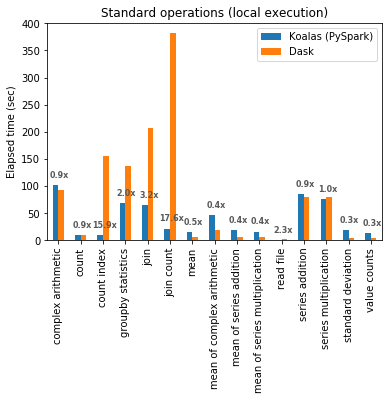

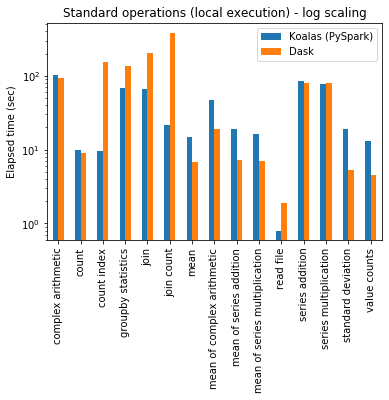

Text(0, 0.5, 'Elapsed time (sec)')

In [0]:
plot_title = 'Standard operations (local execution)'

ax = standard_ops.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")

tmp_df_x_times_faster = standard_ops.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())

standard_ops.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [0]:
tmp_df_x_times_faster

Out[4]:

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,102.382035,92.567438,0.904138,1.106026
count,9.919223,9.076305,0.915022,1.092870
count index,9.729709,154.796565,15.909682,0.062855
groupby statistics,68.253699,136.455982,1.999247,0.500188
join,65.651468,206.813413,3.150172,0.317443
join count,21.688440,381.558525,17.592714,0.056842
mean,14.741346,6.727137,0.456345,2.191325
mean of complex arithmetic,46.341677,18.860008,0.406977,2.457140
mean of series addition,18.989595,7.175950,0.377889,2.646283
mean of series multiplication,16.247608,6.978408,0.429504,2.328269


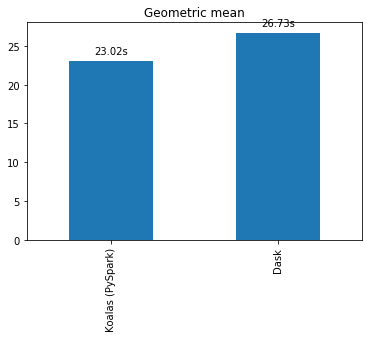

In [0]:
annotate(pd.Series(stats.gmean(standard_ops), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

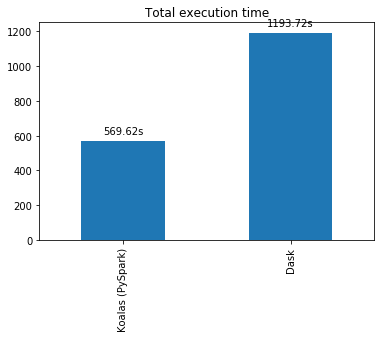

In [0]:
annotate(standard_ops.sum().plot.bar(title='Total execution time'))

In [0]:
print("Performance diff %% (simple avg): %s" % (sum(standard_ops.Dask / standard_ops['Koalas (PySpark)']) / len(standard_ops)))
print("Performance diff %% (geomean): %s" % stats.gmean(standard_ops.Dask / standard_ops['Koalas (PySpark)']))

arithmetic_ops = standard_ops.filter(items=['complex arithmetic', 'series multiplication', 'series addition'], axis=0)
print("Performance diff (arthemetic) %% (simple avg): %s" % (sum(arithmetic_ops.Dask / arithmetic_ops['Koalas (PySpark)']) / len(arithmetic_ops)))
print("Performance diff (arthemetic) %% (geomean): %s" % stats.gmean(arithmetic_ops.Dask / arithmetic_ops['Koalas (PySpark)']))

basic_stats_ops = standard_ops.filter(items=['count', 'mean', 'standard deviation', 'count index', 'join', 'join count'], axis=0)
print("Performance diff (basic stats) %% (simple avg): %s" % (sum(basic_stats_ops.Dask / basic_stats_ops['Koalas (PySpark)']) / len(basic_stats_ops)))
print("Performance diff (basic stats) %% (geomean): %s" % stats.gmean(basic_stats_ops.Dask / basic_stats_ops['Koalas (PySpark)']))

Performance diff % (simple avg): 3.1379990701042995
Performance diff % (geomean): 1.160976398518503
Performance diff (arthemetic) % (simple avg): 0.9645016710988626
Performance diff (arthemetic) % (geomean): 0.9625863048311519
Performance diff (basic stats) % (simple avg): 6.382956836372958
Performance diff (basic stats) % (geomean): 2.15732786302932

### Operations with filtering

Out[9]:

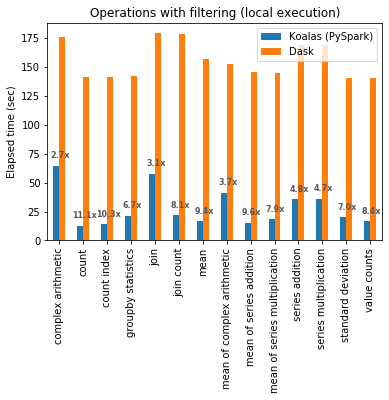

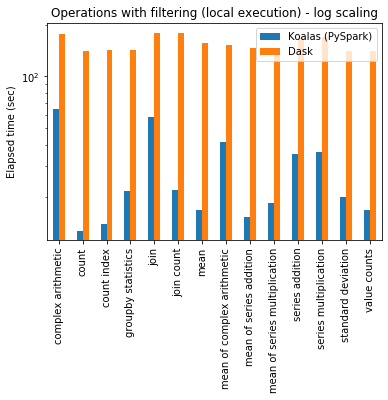

Text(0, 0.5, 'Elapsed time (sec)')

In [0]:
plot_title = 'Operations with filtering (local execution)'

ax = ops_with_filtering.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")

tmp_df_x_times_faster = ops_with_filtering.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())

ops_with_filtering.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [0]:
tmp_df_x_times_faster

Out[10]:

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,64.660164,176.185769,2.724796,0.367000
count,12.692633,141.436250,11.143176,0.089741
count index,13.800224,141.609423,10.261386,0.097453
groupby statistics,21.413724,142.726102,6.665170,0.150034
join,57.806239,179.224980,3.100444,0.322535
join count,21.982469,178.593964,8.124382,0.123086
mean,16.723754,156.696725,9.369710,0.106727
mean of complex arithmetic,41.328726,152.552343,3.691194,0.270915
mean of series addition,15.274264,146.060254,9.562507,0.104575
mean of series multiplication,18.329669,144.841329,7.902015,0.126550


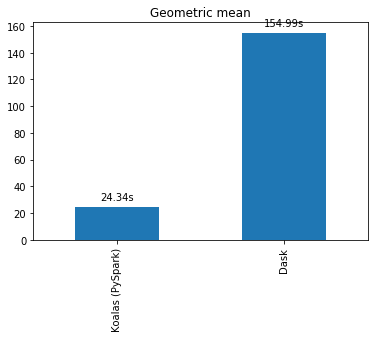

In [0]:
annotate(pd.Series(stats.gmean(ops_with_filtering), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

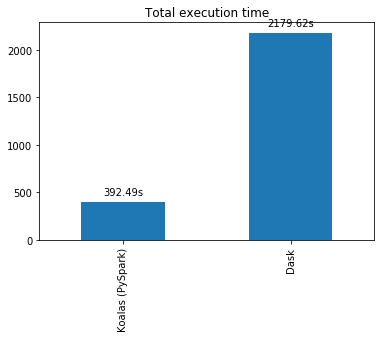

In [0]:
annotate(ops_with_filtering.sum().plot.bar(title='Total execution time'))

In [0]:
print("Performance diff %% (simple avg): %s" % (sum(ops_with_filtering.Dask / ops_with_filtering['Koalas (PySpark)']) / len(ops_with_filtering)))
print("Performance diff %% (geomean): %s" % stats.gmean(ops_with_filtering.Dask / ops_with_filtering['Koalas (PySpark)']))

Performance diff % (simple avg): 6.958667208537091
Performance diff % (geomean): 6.367004494100208

## Operations with filtering and caching

Added caching for the filtered data.

Out[14]:

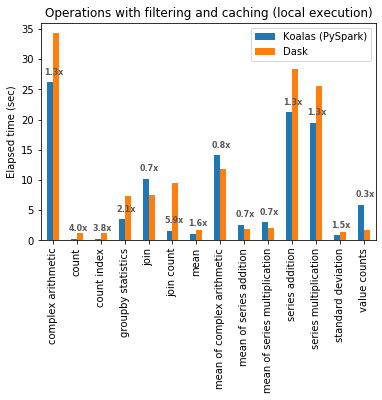

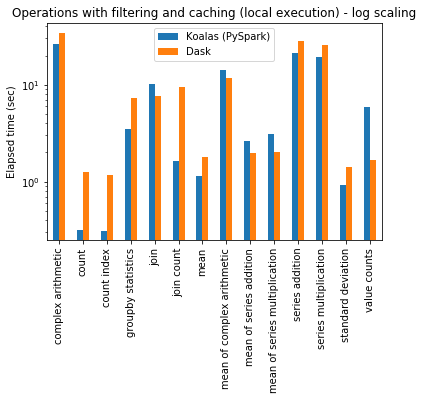

Text(0, 0.5, 'Elapsed time (sec)')

In [0]:
plot_title = 'Operations with filtering and caching (local execution)'

ax = ops_with_filtering_caching.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")

tmp_df_x_times_faster = ops_with_filtering_caching.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())

ops_with_filtering_caching.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [0]:
tmp_df_x_times_faster

Out[15]:

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,26.173041,34.294134,1.310285,0.763193
count,0.316867,1.258570,3.971923,0.251767
count index,0.312935,1.180560,3.772547,0.265073
groupby statistics,3.516905,7.351505,2.090333,0.478393
join,10.214234,7.576409,0.741750,1.348163
join count,1.626026,9.535418,5.864248,0.170525
mean,1.131045,1.799161,1.590707,0.628651
mean of complex arithmetic,14.087999,11.832292,0.839884,1.190640
mean of series addition,2.626669,1.956091,0.744704,1.342816
mean of series multiplication,3.073523,2.014564,0.655458,1.525651


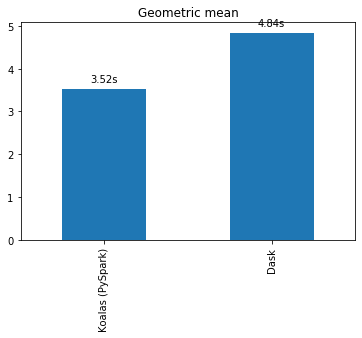

In [0]:
annotate(pd.Series(stats.gmean(ops_with_filtering_caching), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

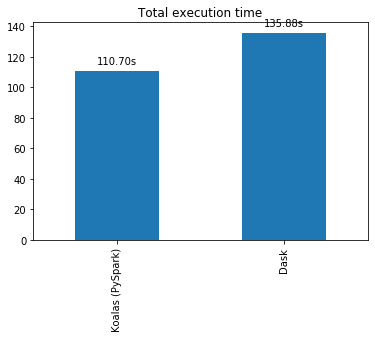

In [0]:
annotate(ops_with_filtering_caching.sum().plot.bar(title='Total execution time'))

In [0]:
print("Performance diff %% (simple avg): %s" % (sum(ops_with_filtering_caching.Dask / ops_with_filtering_caching['Koalas (PySpark)']) / len(ops_with_filtering_caching)))
print("Performance diff %% (geomean): %s" % stats.gmean(ops_with_filtering_caching.Dask / ops_with_filtering_caching['Koalas (PySpark)']))

count_ops = ops_with_filtering_caching.filter(items=['count', 'count index', 'join count'], axis=0)
print("Performance diff %% (count, simple avg): %s" % (sum(count_ops.Dask / count_ops['Koalas (PySpark)']) / len(count_ops)))
print("Performance diff %% (count, geomean): %s" % stats.gmean(count_ops.Dask / count_ops['Koalas (PySpark)']))

Performance diff % (simple avg): 1.859165376337481
Performance diff % (geomean): 1.3755420586876936
Performance diff % (count, simple avg): 4.536239364198507
Performance diff % (count, geomean): 4.445793344069813

## Overall

In [0]:
overall_df = pd.concat([standard_ops, ops_with_filtering, ops_with_filtering_caching])
print("Total performance diff %% (simple avg): %s" % (sum(overall_df.Dask / overall_df['Koalas (PySpark)']) / len(overall_df)))
print("Total performance diff %% (geomean): %s" % stats.gmean(overall_df.Dask / overall_df['Koalas (PySpark)']))

Total performance diff % (simple avg): 3.965573075344384
Total performance diff % (geomean): 2.1352250601762233